In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scrapper import *
from datetime import datetime
import calendar
from dateutil.relativedelta import relativedelta
from multiprocessing import Pool

%matplotlib inline

### Import Data

In [2]:
sue_df = pd.read_csv("actual_sp500_stock_es.csv")
name_df = pd.read_csv("company_name.csv")

In [3]:
sue_df.head()#info()

,OFTIC,anndats,TICKER,MEASURE,FISCALP,PYEAR,PMON,USFIRM,actual,surpmean,surpstdev,suescore
0,A,2000-08-17,AT1,EPS,QTR,2000,7,1,0.39,0.20000,0.01095,17.34455
1,A,2000-08-17,AT1,SAL,QTR,2000,7,1,2670.00,2662.50000,24.74874,0.30305
2,A,2000-11-20,AT1,EPS,QTR,2000,10,1,0.73,0.53556,0.01810,10.74004
3,A,2000-11-20,AT1,SAL,QTR,2000,10,1,3372.00,2998.00000,172.09590,2.17321
4,A,2001-02-20,AT1,EPS,QTR,2001,1,1,0.51,0.44909,0.03477,1.75167


In [4]:
sue_df = sue_df[(sue_df['MEASURE']=='EPS') & (sue_df['USFIRM']==1)]
combine_df = pd.merge(sue_df, name_df, left_on='TICKER', right_on='tic', how='inner')
combine_df.head()

,OFTIC,anndats,TICKER,MEASURE,FISCALP,PYEAR,PMON,USFIRM,actual,surpmean,...,datadate,fyear,indfmt,consol,popsrc,datafmt,tic,conm,curcd,costat
0,AA,2000-01-10,AA,EPS,QTR,1999,12,1,1.335,1.15385,...,20181231,2018,INDL,C,D,STD,AA,ALCOA CORP,USD,A
1,AA,2000-04-06,AA,EPS,QTR,2000,3,1,1.425,1.35625,...,20181231,2018,INDL,C,D,STD,AA,ALCOA CORP,USD,A
2,AA,2000-07-10,AA,EPS,QTR,2000,6,1,1.410,1.41125,...,20181231,2018,INDL,C,D,STD,AA,ALCOA CORP,USD,A
3,AA,2000-10-05,AA,EPS,QTR,2000,9,1,1.260,1.34875,...,20181231,2018,INDL,C,D,STD,AA,ALCOA CORP,USD,A
4,AA,2001-01-08,AA,EPS,QTR,2000,12,1,1.350,1.28250,...,20181231,2018,INDL,C,D,STD,AA,ALCOA CORP,USD,A


### Data Cleaning & Feature Engineering

In [5]:
eps_df = combine_df.loc[:, ['TICKER', 'conm', 'PYEAR', 'PMON', 'suescore']]
eps_df.describe()

,PYEAR,PMON,suescore
count,22737.000000,22737.000000,22472.000000
mean,2009.194617,7.177332,1.434950
std,5.464804,3.415661,4.769791
min,1999.000000,1.000000,-137.628600
25%,2005.000000,3.000000,-0.029235
50%,2009.000000,6.000000,1.028980
75%,2014.000000,9.000000,2.541393
max,2018.000000,12.000000,147.786730


In [6]:
# remove outliers
quantile = eps_df['suescore'].quantile([0.01, 0.99])
center_df = eps_df[(eps_df['suescore']>=quantile.iloc[0]) & (eps_df['suescore']<=quantile.iloc[1])]
center_df.head()

,TICKER,conm,PYEAR,PMON,suescore
0,AA,ALCOA CORP,1999,12,5.64507
1,AA,ALCOA CORP,2000,3,0.53647
2,AA,ALCOA CORP,2000,6,-0.00815
3,AA,ALCOA CORP,2000,9,-0.58508
4,AA,ALCOA CORP,2000,12,0.83302


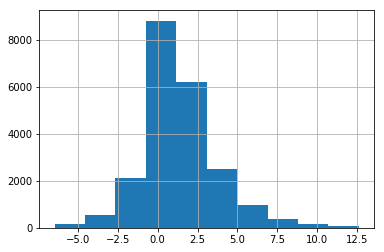

In [7]:
center_df['suescore'].hist()

In [8]:
SCORE_THRESH = 10
pos_surp = eps_df[eps_df['suescore']>=SCORE_THRESH].drop_duplicates()
pos_surp.head()

,TICKER,conm,PYEAR,PMON,suescore
98,AAPL,APPLE INC,2006,12,11.30582
110,AAPL,APPLE INC,2009,12,11.93050
153,ABBV,ABBVIE INC,2014,9,12.92551
313,ADBE,ADOBE INC,2017,2,10.89850
358,ADI,ANALOG DEVICES,2009,4,18.13989


In [9]:
pos_surp['conm'].unique()[:10]

array(['APPLE INC', 'ABBVIE INC', 'ADOBE INC', 'ANALOG DEVICES',
       'ARCHER-DANIELS-MIDLAND CO', 'ACADIA PHARMACEUTICALS INC',
       'AMERICAN ELECTRIC POWER CO', 'ALLERGAN PLC',
       'AMERICAN INTERNATIONAL GROUP', 'APARTMENT INVST & MGMT CO'],
      dtype=object)

### Time Series Analysis

In [10]:
ticker_size = eps_df.groupby(['TICKER']).size()
max_ticker = ticker_size[ticker_size==ticker_size.max()].index[0]
ts_df = eps_df[eps_df['TICKER']==max_ticker]
ts_df['date'] = ts_df.apply(lambda x: pd.to_datetime('{}/{}/01'.format(x['PYEAR'], x['PMON'])), axis=1)
ts_df = ts_df.set_index(['date'])
ts_df = ts_df.resample('Q').last()
ts_df.head()

/Users/niniliu/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


,TICKER,conm,PYEAR,PMON,suescore
date,,,,,
1999-12-31,CB,CHUBB LTD,1999,12,0.23743
2000-03-31,CB,CHUBB LTD,2000,3,-1.72672
2000-06-30,CB,CHUBB LTD,2000,6,0.56470
2000-09-30,CB,CHUBB LTD,2000,9,-1.55563
2000-12-31,CB,CHUBB LTD,2000,12,-3.00000


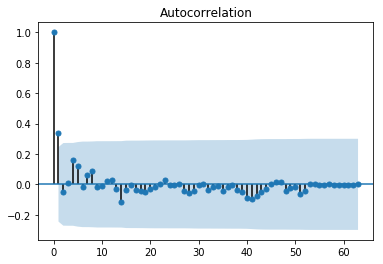

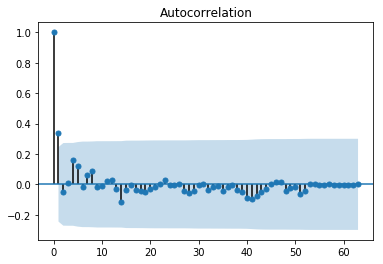

In [11]:
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(ts_df['suescore'])

In [12]:
from arch import arch_model
am = arch_model(ts_df['suescore'])
res = am.fit()

Iteration:      1,   Func. Count:      6,   Neg. LLF: 211.20809228543345
Iteration:      2,   Func. Count:     14,   Neg. LLF: 210.69712025397996
Iteration:      3,   Func. Count:     20,   Neg. LLF: 190.73834013250087
Iteration:      4,   Func. Count:     31,   Neg. LLF: 188.39528687146316
Iteration:      5,   Func. Count:     38,   Neg. LLF: 187.68367641587696
Iteration:      6,   Func. Count:     45,   Neg. LLF: 186.9531101620148
Iteration:      7,   Func. Count:     51,   Neg. LLF: 186.74606716691886
Iteration:      8,   Func. Count:     57,   Neg. LLF: 186.52941582930853
Iteration:      9,   Func. Count:     63,   Neg. LLF: 186.52271195010644
Iteration:     10,   Func. Count:     69,   Neg. LLF: 186.52267678974022
Iteration:     11,   Func. Count:     75,   Neg. LLF: 186.5226497283683
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: 186.52264972832447
            Iterations: 15
            Function evaluations: 75
            Grad

/Users/niniliu/anaconda/lib/python3.6/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


In [13]:
res

                     Constant Mean - GARCH Model Results                      
Dep. Variable:               suescore   R-squared:                      -0.031
Mean Model:             Constant Mean   Adj. R-squared:                 -0.031
Vol Model:                      GARCH   Log-Likelihood:               -186.523
Distribution:                  Normal   AIC:                           381.045
Method:            Maximum Likelihood   BIC:                           389.681
                                        No. Observations:                   64
Date:                Wed, Apr 24 2019   Df Residuals:                       60
Time:                        15:46:55   Df Model:                            4
                               Mean Model                               
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu             1.6244      0.462      3.519  4.330e-04 [  0.720,  2.52

### NLP Processing

In [14]:
pos_surp.head()

,TICKER,conm,PYEAR,PMON,suescore
98,AAPL,APPLE INC,2006,12,11.30582
110,AAPL,APPLE INC,2009,12,11.93050
153,ABBV,ABBVIE INC,2014,9,12.92551
313,ADBE,ADOBE INC,2017,2,10.89850
358,ADI,ANALOG DEVICES,2009,4,18.13989


In [15]:
def get_start_end_date(year, month, frequency='Q'):
    month_end = calendar.monthrange(year, month)[1]
    end_date = datetime(year, month, month_end)
    if frequency == 'Q':
        month_gap = 3
        start_date = end_date - relativedelta(months=month_gap) + relativedelta(days=1)
    return start_date, end_date

In [16]:
news_df = eps_df.copy()
news_df.loc[:, 'start_date'] = news_df.apply(lambda x: get_start_end_date(x['PYEAR'], x['PMON'])[0], axis=1)
news_df.loc[:, 'end_date'] = news_df.apply(lambda x: get_start_end_date(x['PYEAR'], x['PMON'])[1], axis=1)
news_df.head()

,TICKER,conm,PYEAR,PMON,suescore,start_date,end_date
0,AA,ALCOA CORP,1999,12,5.64507,1999-10-01,1999-12-31
1,AA,ALCOA CORP,2000,3,0.53647,2000-01-01,2000-03-31
2,AA,ALCOA CORP,2000,6,-0.00815,2000-03-31,2000-06-30
3,AA,ALCOA CORP,2000,9,-0.58508,2000-07-01,2000-09-30
4,AA,ALCOA CORP,2000,12,0.83302,2000-10-01,2000-12-31


In [17]:
# for i in range(news_df.shape[0]):
#     if i % 1000 == 0:
#         print("... %s loops completed ..." % i)
#     text = read_scrapper(news_df.loc[i, 'conm'], news_df.loc[i, 'start_date'], news_df.loc[i, 'end_date'])
#     try:
#         headlines = [t[1] for t in text]
#         news_df.loc[i, 'headlines'] = ' '.join(headlines)
#     except:
#         news_df.loc[i, 'headlines'] = np.nan

# news_df.to_csv('news.csv')

In [18]:
import re
import spacy

nlp = spacy.load('en_core_web_sm')

def split_sticky_words(ls):
    new_ls = []
    for word in ls:
        for i in range(1, len(word)):
            if word[i].isupper():
                new_ls.extend([word[:i], word[i:]])
    return new_ls

def filter_sticky_words(text):
    # find a list of sticky words
    ls = re.findall("[A-Z][a-z?!\.]+[A-Z][a-z]+", text)
    split_ls = split_sticky_words(ls)
    for i in range(0, len(split_ls), 2):
        tag1 = nlp(split_ls[i])[0].tag_
        tag2 = nlp(split_ls[i+1])[0].tag_
        # the new words should not both be noun
        if (tag1 != 'NNP') or (tag2 != 'NNP'):
            new_word = split_ls[i] + ' ' + split_ls[i+1]
            # replace the original text with splitted words
            text = text.replace(ls[i//2], new_word)
    return text

In [19]:
# unit test
text = "Can You Ace This News Quiz?At Least It's Y2K-Compliant Mining Stocks, \
        Metals Are RecipientsOf Mutual and Equity Funds' Largess DuPont and Dow \
        Chemical FallOn Worries About Fed's Plans Losses from InvestmentsCan Help \
        Trim Tax Bills Tech Stocks Cool for MomentAs Dow Industrials Slide Again \
        Stocks to Watch: American Express, Qualcomm, Apple, Sears, T-Mobile Stocks \
        to Watch: Morgan Stanley, Alcoa, Verizon, La Quinta, Wal-Mart, Amazon, \
        Alphabet, TiVo, BB&T 'New Economy' Stocks JoinDow Jones Industrial Average \
        Blue Chips, Techs AdvanceIn Wake of Fed Rate Move"

filter_sticky_words(text)

"Can You Ace This News Quiz? At Least It's Y2K-Compliant Mining Stocks,         Metals Are Recipients Of Mutual and Equity Funds' Largess DuPont and Dow         Chemical Fall On Worries About Fed's Plans Losses from Investments Can Help         Trim Tax Bills Tech Stocks Cool for Moment As Dow Industrials Slide Again         Stocks to Watch: American Express, Qualcomm, Apple, Sears, T-Mobile Stocks         to Watch: Morgan Stanley, Alcoa, Verizon, La Quinta, Wal-Mart, Amazon,         Alphabet, TiVo, BB&T 'New Economy' Stocks JoinDow Jones Industrial Average         Blue Chips, Techs Advance In Wake of Fed Rate Move"

In [20]:
# read from cached output
news_df = pd.read_csv("news.csv")
news_df.loc[:, 'start_date'] = pd.to_datetime(news_df.loc[:, 'start_date'], format='%Y/%m/%d')
news_df.loc[:, 'end_date'] = pd.to_datetime(news_df.loc[:, 'end_date'], format='%Y/%m/%d')
news_df = news_df.dropna()
news_df.head()

,Unnamed: 0,TICKER,conm,PYEAR,PMON,suescore,start_date,end_date,headlines
0,0,AA,ALCOA CORP,1999,12,5.64507,1999-10-01,1999-12-31,Can You Ace This News Quiz?At Least It's Y2K-C...
1,1,AA,ALCOA CORP,2000,3,0.53647,2000-01-01,2000-03-31,Is There Rationale That Can JustifyNew Economy...
2,2,AA,ALCOA CORP,2000,6,-0.00815,2000-03-31,2000-06-30,European Regulators SealTheir Tough-Guy Reputa...
3,3,AA,ALCOA CORP,2000,9,-0.58508,2000-07-01,2000-09-30,Alcoa's Reduced Profit OutlookLeaves Wall Stre...
4,4,AA,ALCOA CORP,2000,12,0.83302,2000-10-01,2000-12-31,Companies Reduce DividendsAs Their Stock Price...


In [21]:
news_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16888 entries, 0 to 22596
Data columns (total 9 columns):
Unnamed: 0    16888 non-null int64
TICKER        16888 non-null object
conm          16888 non-null object
PYEAR         16888 non-null int64
PMON          16888 non-null int64
suescore      16888 non-null float64
start_date    16888 non-null datetime64[ns]
end_date      16888 non-null datetime64[ns]
headlines     16888 non-null object
dtypes: datetime64[ns](2), float64(1), int64(3), object(3)
memory usage: 1.3+ MB


In [22]:
# separate the words concatenated between headlines
news_df.loc[:, 'headlines'] = news_df.loc[:, 'headlines'].apply(lambda x: filter_sticky_words(x))

In [23]:
# remove punctuations
from nltk.tokenize import RegexpTokenizer

def tokenize_headline(text):
    tokenizer = RegexpTokenizer(r'\w+')
    token_ls = tokenizer.tokenize(text)
    return ' '.join(token_ls)

news_df.loc[:, 'headlines'] = news_df.loc[:, 'headlines'].apply(lambda x: tokenize_headline(x))

In [55]:
news_df.head()

,Unnamed: 0,TICKER,conm,PYEAR,PMON,suescore,start_date,end_date,headlines,label
0,0,AA,ALCOA CORP,1999,12,5.64507,1999-10-01,1999-12-31,Can You Ace This News Quiz At Least It s Y2K C...,1.0
1,1,AA,ALCOA CORP,2000,3,0.53647,2000-01-01,2000-03-31,Is There Rationale That Can Justify New Econom...,0.0
2,2,AA,ALCOA CORP,2000,6,-0.00815,2000-03-31,2000-06-30,European Regulators Seal Their Tough Guy Reput...,0.0
3,3,AA,ALCOA CORP,2000,9,-0.58508,2000-07-01,2000-09-30,Alcoa s Reduced Profit Outlook Leaves Wall Str...,-1.0
4,4,AA,ALCOA CORP,2000,12,0.83302,2000-10-01,2000-12-31,Companies Reduce Dividends As Their Stock Pric...,0.0


In [56]:
news_df.to_csv("news_split.csv")

In [19]:
news_df = pd.read_csv("news_split.csv")
news_df.loc[:, 'start_date'] = pd.to_datetime(news_df.loc[:, 'start_date'], format='%Y/%m/%d')
news_df.loc[:, 'end_date'] = pd.to_datetime(news_df.loc[:, 'end_date'], format='%Y/%m/%d')
news_df = news_df.dropna()
news_df.head()

,Unnamed: 0,Unnamed: 0.1,TICKER,conm,PYEAR,PMON,suescore,start_date,end_date,headlines,label
0,0,0,AA,ALCOA CORP,1999,12,5.64507,1999-10-01,1999-12-31,Can You Ace This News Quiz At Least It s Y2K C...,1.0
1,1,1,AA,ALCOA CORP,2000,3,0.53647,2000-01-01,2000-03-31,Is There Rationale That Can Justify New Econom...,0.0
2,2,2,AA,ALCOA CORP,2000,6,-0.00815,2000-03-31,2000-06-30,European Regulators Seal Their Tough Guy Reput...,0.0
3,3,3,AA,ALCOA CORP,2000,9,-0.58508,2000-07-01,2000-09-30,Alcoa s Reduced Profit Outlook Leaves Wall Str...,-1.0
4,4,4,AA,ALCOA CORP,2000,12,0.83302,2000-10-01,2000-12-31,Companies Reduce Dividends As Their Stock Pric...,0.0


In [39]:
# create labels
news_df.suescore.describe()
# news_df[news_df.suescore==news_df.suescore.min()].headlines.values

def label_sentiment(x, lower_q=0.25, higher_q=0.75):
    l = np.quantile(x, lower_q)
    h = np.quantile(x, higher_q)
    new_ls = x.copy().values
    for i in range(len(new_ls)):
        # positive sentiment
        if new_ls[i] >= h:
            new_ls[i] = 1
        # negative sentiment
        elif new_ls[i] <= l:
            new_ls[i] = -1
        # neutral
        else:
            new_ls[i] = 0
    return new_ls

news_df.loc[:, 'label'] = label_sentiment(news_df.loc[:, 'suescore'])

In [40]:
news_df.head()

,Unnamed: 0,TICKER,conm,PYEAR,PMON,suescore,start_date,end_date,headlines,label
0,0,AA,ALCOA CORP,1999,12,5.64507,1999-10-01,1999-12-31,Can You Ace This News Quiz? At Least It's Y2K-...,1.0
1,1,AA,ALCOA CORP,2000,3,0.53647,2000-01-01,2000-03-31,Is There Rationale That Can Justify New Econom...,0.0
2,2,AA,ALCOA CORP,2000,6,-0.00815,2000-03-31,2000-06-30,European Regulators Seal Their Tough-Guy Reput...,0.0
3,3,AA,ALCOA CORP,2000,9,-0.58508,2000-07-01,2000-09-30,Alcoa's Reduced Profit Outlook Leaves Wall Str...,-1.0
4,4,AA,ALCOA CORP,2000,12,0.83302,2000-10-01,2000-12-31,Companies Reduce Dividends As Their Stock Pric...,0.0


### Fit Algorithms

In [25]:
from spacy.lang.en.stop_words import STOP_WORDS
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import GridSearchCV

In [26]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(news_df['headlines'], news_df['label'],
                                                    test_size=0.2, random_state=42)

In [27]:
def tokenize_lemma(text):
    return [w.lemma_ for w in nlp(text)]

stop_words_lemma = set(w.lemma_ for w in nlp(' '.join(STOP_WORDS)))

In [36]:
# bag of words
from sklearn.feature_extraction.text import CountVectorizer

bag_of_words_vectorizer = CountVectorizer(max_features=300, 
                                          ngram_range=(2,2), 
                                          stop_words=stop_words_lemma,
                                          #tokenizer=tokenize_lemma,
                                          token_pattern="\w\w+ \w\w+")

# print(bag_of_words_vectorizer.get_feature_names())
X = bag_of_words_vectorizer.fit_transform(X_train[:10])
print(X.toarray(), bag_of_words_vectorizer.get_feature_names())

[[ 0  1  0 ...  0  0  1]
 [ 0  0  0 ...  0  0  0]
 [ 1  0  0 ...  0  0  0]
 ...
 [ 0  0  0 ...  0  0  0]
 [ 0 52  2 ...  1  0 52]
 [ 0  0  0 ...  0  0  0]] ['10 highest paid software', 'chain and logistics news', 'from wsj donald trump', 'from wsj the morning', 'from wsj top supply', 'journal today top supply', 'lennar cisco systems the', 'lifts guidance as profit', 'lineup how quantum computer', 'loans sec eyes charles', 'lobbyists to advise on', 'logistics news from wsj', 'long economic malaise college', 'look at his proposed', 'look for new comrades', 'looks for buyer in', 'looks to set emerging', 'loosen sarbanes oxley act', 'loss in 2015 heavy', 'lost disney business don', 'low prices intel earnings', 'lure customers donald trump', 'magento commerce 68 billion', 'mainstream hasbro to make', 'make good on vow', 'maker cavium the morning', 'makers are adding brains', 'makers stocks to watch', 'makes compliance inroads today', 'makes the case for', 'making life miserable for', 'malai

In [74]:
bag_of_words_vectorizer.get_feature_names()

['1',
 '2',
 '3',
 '4',
 '5',
 'acquire',
 'ad',
 'add',
 'agree',
 'ahead',
 'aig',
 'aim',
 'air',
 'airline',
 'amazon',
 'america',
 'american',
 'amid',
 'apple',
 'asia',
 'asian',
 'asset',
 'auto',
 'bad',
 'bank',
 'battle',
 'beat',
 'bet',
 'bid',
 'big',
 'big price',
 'bill',
 'billion',
 'board',
 'boee',
 'bond',
 'book',
 'boost',
 'brand',
 'brief',
 'build',
 'business',
 'buy',
 'capital',
 'car',
 'card',
 'case',
 'cash',
 'ceo',
 'chain',
 'chain logistic',
 'challenge',
 'change',
 'charge',
 'chief',
 'china',
 'china s',
 'chinese',
 'chip',
 'close',
 'cloud',
 'com',
 'come',
 'company',
 'concern',
 'consumer',
 'continue',
 'corporate',
 'cost',
 'court',
 'credit',
 'cut',
 'datum',
 'day',
 'deal',
 'debt',
 'decline',
 'demand',
 'despite',
 'dollar',
 'donald',
 'dow',
 'download',
 'drive',
 'drop',
 'drug',
 'e',
 'earning',
 'economy',
 'end',
 'energy',
 'eu',
 'europe',
 'european',
 'executive',
 'expand',
 'expect',
 'face',
 'facebook',
 'fall',

In [68]:
est = Pipeline([('vectorizer', TfidfVectorizer(ngram_range=(1,2),
                                               stop_words=stop_words_lemma,
                                               tokenizer=tokenize_lemma)),
                ('classifier', MultinomialNB())])

est.fit(X_train,y_train) # This may take 2 or 3 minutes to run 
est.score(X_test,y_test) 

/Users/niniliu/anaconda/lib/python3.6/site-packages/sklearn/feature_extraction/text.py:301: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['-pron-'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


0.4955595026642984

In [47]:
sgd_pipe = Pipeline([('vectorizer', TfidfVectorizer(ngram_range=(1,2),
                                               stop_words=STOP_WORDS)), # lemmatization removed to improve runtime
                     ('classifier', SGDClassifier(max_iter=5))])         

parameters = {'vectorizer__ngram_range': [(1, 1), (1, 2)], 
              'classifier__alpha': (0.001, 0.0001, 0.00001),
              'classifier__loss': ('log', 'hinge'), # log = Logistic Regression, hinge = Linear SVM
}

grid = GridSearchCV(sgd_pipe, parameters, cv=5)
grid.fit(X_train,y_train) # This may take 2 or 3 minutes to run 

est = grid.best_estimator_  #  Let's have a closer look at the best parameters...
est.score(X_test,y_test) 

/Users/niniliu/anaconda/lib/python3.6/site-packages/sklearn/feature_extraction/text.py:301: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ll', 've'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
/Users/niniliu/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
/Users/niniliu/anaconda/lib/python3.6/site-packages/sklearn/feature_extraction/text.py:301: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ll', 've'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
/Users/nini

/Users/niniliu/anaconda/lib/python3.6/site-packages/sklearn/feature_extraction/text.py:301: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ll', 've'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
/Users/niniliu/anaconda/lib/python3.6/site-packages/sklearn/feature_extraction/text.py:301: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ll', 've'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
/Users/niniliu/anaconda/lib/python3.6/site-packages/sklearn/feature_extraction/text.py:301: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ll', 've'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
/Users/niniliu/anaconda/lib/python3.6/site-packages/sklearn/feature_extraction/text.py:301: UserWarning: Your stop_words may be inconsistent with your prepro

/Users/niniliu/anaconda/lib/python3.6/site-packages/sklearn/feature_extraction/text.py:301: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ll', 've'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
/Users/niniliu/anaconda/lib/python3.6/site-packages/sklearn/feature_extraction/text.py:301: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ll', 've'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
/Users/niniliu/anaconda/lib/python3.6/site-packages/sklearn/feature_extraction/text.py:301: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ll', 've'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


0.5991711071640023

Pipeline(memory=None,
     steps=[('vectorizer', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.float64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 2), norm='l2', preprocessor=None, smooth_idf=...m_state=None, shuffle=True, tol=None,
       validation_fraction=0.1, verbose=0, warm_start=False))])